# GAN Pix2Pix pour la segmentation médicale

Ce notebook implémente un réseau antagoniste génératif (GAN) pour la segmentation d'images. L'objectif est de transformer des scans CT en masques de segmentation précis.

## Import

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import random
import torchvision.transforms.functional as TF

## Préparation des données et du Dataset

Cette classe hérite de l'objet Dataset de PyTorch pour automatiser le chargement des données. Elle assure la lecture des images denses et de leurs masques de segmentation associés. L'utilisation d'un DataLoader permet ensuite de gérer le passage des données par lots durant l'entraînement.

In [ ]:
# --- 1. Dataset Robuste ---
class MedicalPix2PixDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.mode = mode
        self.image_dir = "data/X_train/images"
        self.mask_dir = "data/Supp_train/segmentations/"  
        self.files = sorted(os.listdir(self.image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        
        # Charger Scan 
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("L")

        # Charger Masque
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = Image.open(mask_path) 

        # Augmentation Synchronisée
        if self.mode == 'train':
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

        # Transformation en Tensor
        # Scan : Normalisé entre -1 et 1 pour le GAN
        scan_tensor = transforms.ToTensor()(image) 
        scan_tensor = (scan_tensor - 0.5) / 0.5 

        # Masque
        mask_tensor = np.array(mask)
        mask_tensor = torch.from_numpy(mask_tensor).long()
        
        return scan_tensor, mask_tensor

## Architecture du Générateur (U-Net)

Le générateur repose sur une structure U-Net. Ce réseau prend un scan médical en entrée et produit un masque. Il utilise des blocs de convolution pour compresser l'information. Puis des blocs de déconvolution reconstruisent l'image. Des connexions "skip" relient les étapes de compression et de reconstruction. Cela permet de conserver les détails anatomiques précis du patient.

In [ ]:
# --- 2. Générateur U-Net (Mask -> Scan) ---
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetGenerator, self).__init__()
        # Blocs de convolution et dé-convolution
        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize: layers.append(nn.InstanceNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(out_feat),
                nn.ReLU(inplace=True)
            ]
            if dropout: layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        # Encodeur
        self.d1 = down_block(in_channels, 64, normalize=False)
        self.d2 = down_block(64, 128)
        self.d3 = down_block(128, 256)
        self.d4 = down_block(256, 512)
        self.d5 = down_block(512, 512) 

        # Décodeur
        self.u1 = up_block(512, 512, dropout=0.5)
        self.u2 = up_block(1024, 256) # Concatenation d4 + u1 = 512+512 = 1024
        self.u3 = up_block(512, 128)
        self.u4 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh() # Sortie Scan [-1, 1]
        )

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        
        u1 = self.u1(d5)
        u2 = self.u2(torch.cat([u1, d4], 1)) # Skip connection
        u3 = self.u3(torch.cat([u2, d3], 1))
        u4 = self.u4(torch.cat([u3, d2], 1))
        
        return self.final(torch.cat([u4, d1], 1))


## Architecture du Discriminateur (PatchGAN)

Le discriminateur utilise une architecture PatchGAN. Il ne regarde pas l'image entière comme un seul bloc. Il analyse des petites zones ou "patchs" de pixels. Le réseau détermine si chaque zone est réelle ou produite par le générateur. Cette méthode force le générateur à produire des textures très réalistes et des bords nets.

In [ ]:
# --- 3. Discriminateur (Juge les paires) ---
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=1): # in_channels = Scan (1) + Mask (1)
        super(PatchDiscriminator, self).__init__()

        def disc_block(in_f, out_f, normalize=True):
            layers = [nn.Conv2d(in_f, out_f, 4, 2, 1)]
            if normalize: layers.append(nn.InstanceNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *disc_block(2, 64, normalize=False), # Entrée : Scan + Mask
            *disc_block(64, 128),
            *disc_block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Entraînement et Fonctions de perte

L'entraînement repose sur un équilibre entre deux réseaux. Le générateur tente de tromper le discriminateur. Le discriminateur apprend à mieux détecter les faux. On utilise une combinaison de deux pertes. La perte binaire (BCE) gère l'aspect compétitif du GAN. La perte L1 assure que le masque généré ressemble physiquement à la vérité terrain.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# --- Configuration Optimisée ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR_G = 0.0002      
LR_D = 0.00005      
EPOCHS = 200
BATCH_SIZE = 8
N_CLASSES = 105      # nombre de classes de segmentation pour les 200 images
LAMBDA_PIXEL = 100  # Poids de la perte L1


# --- Initialisation ---
generator = UNetGenerator(in_channels=1, out_channels=1).to(DEVICE)
discriminator = PatchDiscriminator(in_channels=1).to(DEVICE)

# Optimiseurs avec Learning Rates différents
opt_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

# Fonctions de perte
criterion_GAN = nn.MSELoss()  
criterion_pixel = nn.L1Loss()

# Dataset
dataset = MedicalPix2PixDataset( mode='train')
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"[INFO] Démarrage sur {DEVICE} avec Label Smoothing et LR asymétriques...")

# --- Boucle d'Entraînement ---
for epoch in range(EPOCHS):
    for i, (real_scan, mask) in enumerate(loader):
        
        # Transfert GPU
        real_scan = real_scan.to(DEVICE)
        
        # Préparation du masque (Normalisation [0, 1] pour le réseau)
        mask_input = mask.unsqueeze(1).float().to(DEVICE) / N_CLASSES

        # Création des labels pour le Discriminateur
        valid = torch.full((real_scan.size(0), 1, 30, 30), 0.9, device=DEVICE)
        fake = torch.full((real_scan.size(0), 1, 30, 30), 0.0, device=DEVICE)

        #  1. Train GENERATOR
        opt_G.zero_grad()

        # Générer l'image
        fake_scan = generator(mask_input)

        # Perte Adversariale : Le générateur veut que D dise "C'est valide (0.9)"
        pred_fake = discriminator(mask_input, fake_scan)
        
        # Le discriminateur sort une grille (PatchGAN), on adapte la taille de 'valid' si besoin
        loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake) * 0.9)

        # Perte Pixel (L1)
        loss_pixel = criterion_pixel(fake_scan, real_scan)

        # Total Loss G
        loss_G = loss_GAN + (LAMBDA_PIXEL * loss_pixel)
        
        loss_G.backward()
        opt_G.step()

        #  2. Train DISCRIMINATOR
        if i % 2 == 0:
            opt_D.zero_grad()

            # A. Vrai couple (Masque + Vrai Scan)
            pred_real = discriminator(mask_input, real_scan)
            loss_real = criterion_GAN(pred_real, torch.ones_like(pred_real) * 0.9) # Label 0.9

            # B. Faux couple (Masque + Faux Scan détâché)
            pred_fake = discriminator(mask_input, fake_scan.detach())
            loss_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake)) # Label 0.0

            loss_D = 0.5 * (loss_real + loss_fake)
            
            loss_D.backward()
            opt_D.step()
        
        else:
            # Si on ne met pas à jour D, on garde la valeur précédente pour l'affichage
            if 'loss_D' not in locals(): loss_D = torch.tensor(0.0)

    # --- Logs et Sauvegarde ---
    print(f"[Epoch {epoch}/{EPOCHS}] Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    # Sauvegarder une image témoin à chaque fin d'époque pour vérifier que ce n'est pas noir
    if epoch % 10 == 0:
        with torch.no_grad():
            # Dénormalisation pour visualisation : (-1,1) -> (0,1)
            vis_scan = fake_scan[0] * 0.5 + 0.5 
            save_image(vis_scan, f"sample_{epoch}.png")
            
        torch.save(generator.state_dict(), "pix2pix_generator.pth")

print("Entraînement terminé.")

## Génération

In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 105 # Nombre de classes dans les masques si on prend les 200 images

def generate_augmented_data(model_path, source_mask_dir, output_dir, n_aug=1):
    """
    Génère des données synthétiques avec des déformations anatomiques avancées.
    Intègre : Rotation, Zoom, Translation, Cisaillement, et Déformation Élastique.
    """
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
    
    # 1. Chargement du Modèle
    gen = UNetGenerator().to(DEVICE)
    gen.load_state_dict(torch.load(model_path, map_location=DEVICE))
    gen.eval()

    mask_files = [f for f in os.listdir(source_mask_dir) if f.endswith('.png')]
    print(f"[INFO] Génération de {n_aug} variantes complexes pour chaque masque...")

    # 2. Définition du pipeline d'augmentation pour les MASQUES
    aug_pipeline = transforms.Compose([
        # A. Flip Horizontal - 50% de chance
        transforms.RandomHorizontalFlip(p=0.5),
        
        # B. Transformations Affines (Rotation, Translation, Scale, Shear)
        transforms.RandomAffine(
            degrees=20,             # Rotation +/- 20°
            translate=(0.1, 0.1),   # Décalage horizontal/vertical de 10%
            scale=(0.85, 1.15),     # Zoom entre 85% et 115%
            shear=10,               # Cisaillement (déformation oblique) +/- 10°
            interpolation=transforms.InterpolationMode.NEAREST
        ),
        
        # C. Déformation Élastique (Le plus important pour le "mou")
        # alpha contrôle l'intensité de la déformation
        transforms.RandomApply([
            transforms.ElasticTransform(alpha=50.0, sigma=5.0, interpolation=transforms.InterpolationMode.NEAREST)
        ], p=0.5),
    ])

    count = 0
    for f in mask_files:
        mask_path = os.path.join(source_mask_dir, f)
        
        # Charger le masque original
        mask_pil = Image.open(mask_path)
        
        for i in range(n_aug):
            # --- ETAPE 1 : Augmentation Géométrique ---
            # On applique le pipeline défini plus haut
            new_mask_pil = aug_pipeline(mask_pil)
            
            # --- ETAPE 2 : Préparation pour le GAN ---
            # Conversion en Tensor et Normalisation
            mask_tensor = torch.from_numpy(np.array(new_mask_pil)).long()

            mask_input = mask_tensor.unsqueeze(0).unsqueeze(0).float().to(DEVICE) / N_CLASSES
            
            # --- ETAPE 3 : Génération du Scan Synthétique ---
            with torch.no_grad():
                fake_scan = gen(mask_input)
            
            # --- ETAPE 4 : Sauvegarde ---
            save_name = f"aug_{count}_{f}"
            
            # A. Sauvegarde Scan (Dénormaliser -1..1 -> 0..255)
            scan_np = fake_scan.squeeze().cpu().numpy()
            scan_np = ((scan_np + 1) / 2 * 255).astype(np.uint8)
            Image.fromarray(scan_np).save(os.path.join(output_dir, "images", save_name))
            
            # B. Sauvegarde Masque (On sauvegarde le masque transformé)
            new_mask_pil.save(os.path.join(output_dir, "masks", save_name))
            
            count += 1
            if count % 100 == 0:
                print(f"  -> {count} paires générées...")

    print(f"[TERMINE] {count} images générées dans '{output_dir}'")

generate_augmented_data("saved_models/pix2pix_generator.pth", "data/Supp_train/segmentations/", "./ganData")

[INFO] Génération de 1 variantes complexes pour chaque masque...
  -> 100 paires générées...
  -> 200 paires générées...
[TERMINE] 200 images générées dans './ganData'


In [ ]:
import matplotlib.pyplot as plt

def plot_pair(image_input, mask_input, title="Comparaison Image/Masque"):
    """
    Supporte les chemins de fichiers (str), les Tenseurs PyTorch et les Tableaux NumPy.
    """
    # 1. Traitement du CT-Scan
    if isinstance(image_input, str):
        # Chargement depuis le disque
        img_np = np.array(Image.open(image_input).convert("L"))
        img_np = img_np / 255.0  # Normalisation [0, 1] pour affichage
    elif isinstance(image_input, torch.Tensor):
        img_np = image_input.squeeze().cpu().detach().numpy()
        # Dénormalisation si l'image est en [-1, 1] (sortie du GAN)
        if img_np.min() < -0.1:
            img_np = (img_np * 0.5) + 0.5
    else:
        img_np = image_input

    # 2. Traitement du Masque
    if isinstance(mask_input, str):
        # Chargement depuis le disque
        mask_np = np.array(Image.open(mask_input))
    elif isinstance(mask_input, torch.Tensor):
        mask_np = mask_input.squeeze().cpu().detach().numpy()
    else:
        mask_np = mask_input

    # 3. Affichage
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("CT-Scan")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='tab20') 
    plt.title("Masque de Segmentation")
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

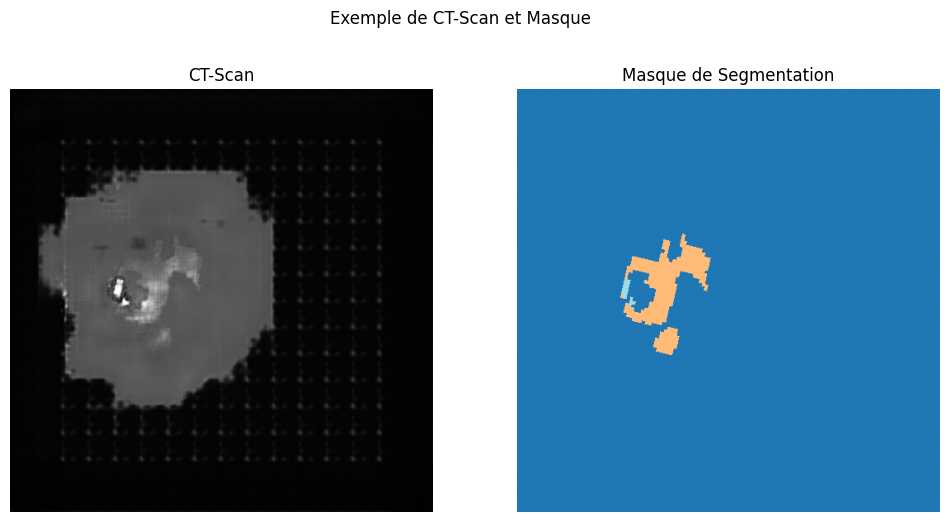

In [9]:
plot_pair("ganData/images/aug_0_132.png", "ganData/masks/aug_0_132.png", title="Exemple de CT-Scan et Masque")

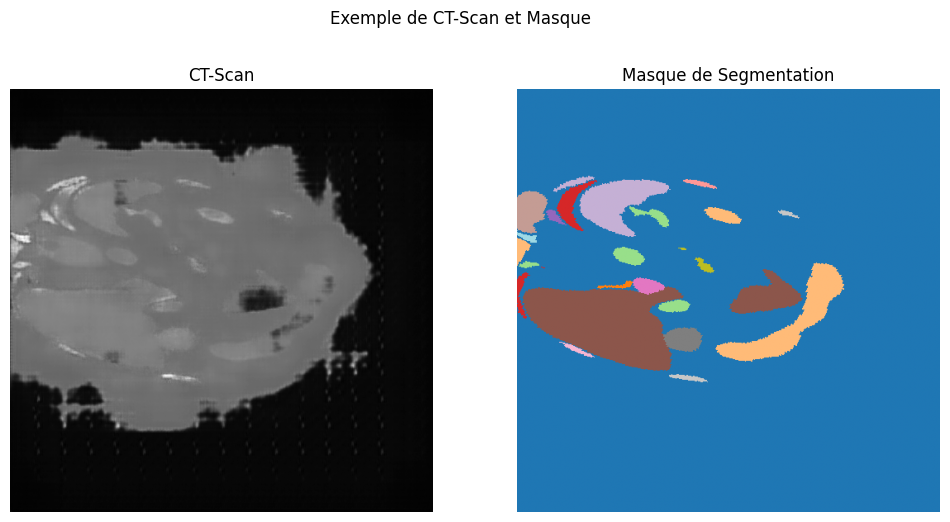

In [12]:
plot_pair("ganData/images/aug_1_82.png", "ganData/masks/aug_1_82.png", title="Exemple de CT-Scan et Masque")